In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

diabetes_path = "/content/drive/MyDrive/Connection/diabetes_.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Problem - 1: Perform a classification task with knn from scratch.

In [7]:
# Step 1: Load the Dataset
import pandas as pd
import numpy as np

diabetes_path = "/content/drive/MyDrive/Connection/diabetes_.csv"
df = pd.read_csv(diabetes_path)

# Display first few rows
print(df.head())

# Exploratory Data Analysis (EDA)
print(df.info())          # Check data types and missing values
print(df.describe())      # Summary statistics
print(df.isnull().sum())  # Count of missing values

# Step 2: Handle Missing Data
# Fill numeric columns with mean (most diabetes datasets are numeric)
for column in df.columns:
    if df[column].dtype != 'object':
        df[column] = df[column].fillna(df[column].mean())
    else:
        df[column] = df[column].fillna(df[column].mode()[0])

# Step 3: Feature Engineering
# Last column is the target
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Train-test split from scratch (70% train, 30% test)
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

train_size = int(0.7 * X.shape[0])
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Step 4: Implement KNN
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def predict_single(X_train, y_train, query, k=3):
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(X_train[i], query)
        distances.append((dist, y_train[i]))
    distances.sort(key=lambda x: x[0])
    neighbors = distances[:k]

    # Majority vote
    classes = [neighbor[1] for neighbor in neighbors]
    prediction = max(set(classes), key=classes.count)
    return prediction

def predict_all(X_train, y_train, X_test, k=3):
    predictions = []
    for query in X_test:
        pred = predict_single(X_train, y_train, query, k)
        predictions.append(pred)
    return np.array(predictions)

# Step 5: Evaluate Performance
k = 5  # You can change k to see which performs best
y_pred = predict_all(X_train, y_train, X_test, k)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy:.2f}")

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768

Problem - 2 - Experimentation:

In [8]:
# Step 1: Scale the Feature Matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split from scratch (70% train, 30% test) on scaled data
np.random.seed(42)
indices = np.arange(X_scaled.shape[0])
np.random.shuffle(indices)

train_size = int(0.7 * X_scaled.shape[0])
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train_scaled, X_test_scaled = X_scaled[train_indices], X_scaled[test_indices]
y_train_scaled, y_test_scaled = y[train_indices], y[test_indices]

# Step 2: KNN on Scaled Data (reuse previous functions)
k = 5
y_pred_scaled = predict_all(X_train_scaled, y_train_scaled, X_test_scaled, k)
accuracy_scaled = np.sum(y_pred_scaled == y_test_scaled) / len(y_test_scaled)
print(f'Accuracy of KNN classifier on scaled data: {accuracy_scaled*100:.2f}%')

# Step 3: Compare with original data
print(f'Accuracy on original data: {accuracy*100:.2f}%')
print(f'Accuracy on scaled data:   {accuracy_scaled*100:.2f}%')

# Step 4: Discussion
if accuracy_scaled > accuracy:
    print("\nScaling improved KNN performance because all features contribute equally to distance calculation.")
elif accuracy_scaled < accuracy:
    print("\nScaling slightly reduced performance, possibly because some features lost natural weight, but usually it improves or stabilizes results.")
else:
    print("\nScaling did not change accuracy significantly.")

Accuracy of KNN classifier on scaled data: 74.03%
Accuracy on original data: 71.43%
Accuracy on scaled data:   74.03%

Scaling improved KNN performance because all features contribute equally to distance calculation.


Problem - 3 - Experimentation with k:

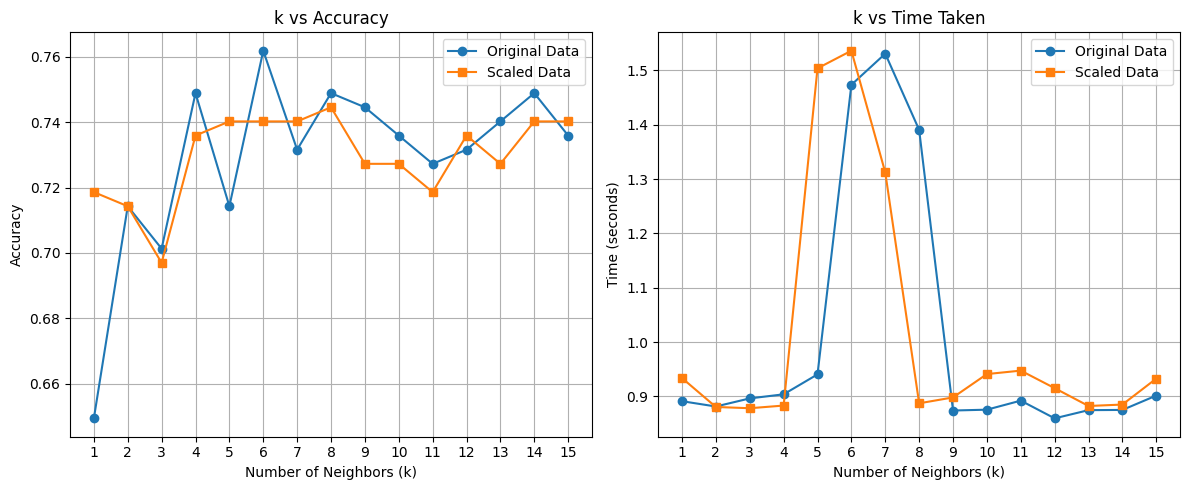

Optimal k for Original Data: 6 with accuracy 76.19%
Optimal k for Scaled Data:   8 with accuracy 74.46%

Discussion:
- Accuracy usually increases with small k but may drop for very small or very large k (overfitting vs underfitting).
- Scaling generally improves accuracy because all features contribute equally to distance.
- Computation time increases slightly with k since more neighbors are considered, but the effect is small for small datasets.


In [9]:
import time
import matplotlib.pyplot as plt

# Function to run KNN for multiple k values and record accuracy and time
def knn_experiment(X_train, y_train, X_test, y_test, k_values):
    accuracies = []
    times = []

    for k in k_values:
        start_time = time.time()
        y_pred = predict_all(X_train, y_train, X_test, k)
        end_time = time.time()

        accuracy = np.sum(y_pred == y_test) / len(y_test)
        elapsed_time = end_time - start_time

        accuracies.append(accuracy)
        times.append(elapsed_time)

    return accuracies, times

# Define k range
k_values = list(range(1, 16))

# Run on original data
acc_orig, time_orig = knn_experiment(X_train, y_train, X_test, y_test, k_values)

# Run on scaled data
acc_scaled, time_scaled = knn_experiment(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, k_values)

# Step 2: Visualize Results
plt.figure(figsize=(12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(k_values, acc_orig, marker='o', label='Original Data')
plt.plot(k_values, acc_scaled, marker='s', label='Scaled Data')
plt.title('k vs Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)

# Time Plot
plt.subplot(1,2,2)
plt.plot(k_values, time_orig, marker='o', label='Original Data')
plt.plot(k_values, time_scaled, marker='s', label='Scaled Data')
plt.title('k vs Time Taken')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Time (seconds)')
plt.xticks(k_values)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 3: Analysis
optimal_k_orig = k_values[np.argmax(acc_orig)]
optimal_k_scaled = k_values[np.argmax(acc_scaled)]
print(f"Optimal k for Original Data: {optimal_k_orig} with accuracy {max(acc_orig)*100:.2f}%")
print(f"Optimal k for Scaled Data:   {optimal_k_scaled} with accuracy {max(acc_scaled)*100:.2f}%")

print("\nDiscussion:")
print("- Accuracy usually increases with small k but may drop for very small or very large k (overfitting vs underfitting).")
print("- Scaling generally improves accuracy because all features contribute equally to distance.")
print("- Computation time increases slightly with k since more neighbors are considered, but the effect is small for small datasets.")


Problem - 4 - Additional Questions

In [14]:
import numpy as np

# Euclidean distance function
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# Function for KNN prediction for a single query
def knn_predict_single(query, X_train, y_train, k=3):
    """
    Predict the class label for a single query using the K-nearest neighbors algorithm.

    Arguments:
    query : np.ndarray
        The query point for which the prediction is to be made.
    X_train : np.ndarray
        The training feature matrix.
    y_train : np.ndarray
        The training labels (integer encoded).
    k : int, optional
        The number of nearest neighbors to consider (default is 3).

    Returns:
    int
        The predicted class label for the query.
    """
    # Compute distances to all training points
    distances = np.array([euclidean_distance(query, x) for x in X_train])

    # Get indices of k nearest neighbors
    nearest_indices = np.argsort(distances)[:k]

    # Get labels of k nearest neighbors
    nearest_labels = y_train[nearest_indices]

    # Majority vote
    prediction = np.bincount(nearest_labels).argmax()
    return prediction

In [15]:
# Demonstrate the use of knn_predict_single

# Pick a sample query point from the scaled test set
sample_query_point = X_test_scaled[0]

# Predict the class label for the sample query point using k=5
predicted_label = knn_predict_single(sample_query_point, X_train_scaled, y_train_scaled, k=5)

# Get the actual label for comparison
actual_label = y_test_scaled[0]

print(f"Sample Query Point (scaled): {sample_query_point}")
print(f"Predicted Label: {predicted_label}")
print(f"Actual Label: {actual_label}")

if predicted_label == actual_label:
    print("Prediction is correct!")
else:
    print("Prediction is incorrect.")

Sample Query Point (scaled): [-0.84488505 -0.99820778 -2.33185124 -0.09637905 -0.47581817 -0.53211885
  0.26312391 -1.04154944]
Predicted Label: 0
Actual Label: 0
Prediction is correct!
